In [1]:
!pip install mdtraj
#!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import mdtraj as md
import sys
sys.path.append('/content/drive/MyDrive/AF2RAVE-Glide/kinase_Aloop/')
import kinaseCVs as kcv
import os
from sklearn.cluster import KMeans
# from rdkit import Chem
# from rdkit.Chem import rdFMCS
# import matplotlib.cm as cm
# from rdkit.Chem import Draw
# from rdkit.Chem import AllChem
# from CalcLigRMSD import *
import gzip

In [4]:
!pip install biopython
from Bio.PDB import PDBParser
import glob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 8.2 MB/s eta 0:00:00


In [5]:
import re

In [6]:
def align_sidechain_atomid(resid, ref_resid, top, ref_top):
    id1=[]
    id2=[]
    for i in range(len(resid)):
        tmp1 = top.select(f'resSeq {resid[i]} and sidechain and element != "H"')
        tmp2 = ref_top.select(f'resSeq {ref_resid[i]} and sidechain and element != "H"')
        a1_dict={}
        a2_dict={}
        for j in range(len(tmp1)):
            atom1 = top.atom(tmp1[j])
            a1_dict[tmp1[j]] = atom1.name

        for j in range(len(tmp2)):
            atom2 = ref_top.atom(tmp2[j])
            a2_dict[atom2.name] = tmp2[j]

        for j in range(len(tmp1)):
            if a1_dict[tmp1[j]] in a2_dict.keys():
                id1.append(tmp1[j])
                id2.append(a2_dict[a1_dict[tmp1[j]]])

    # check the atomic alignment
    for i in range(len(id1)):
        if str(top.atom(id1[i]).residue)[:3] != str(ref_top.atom(id2[i]).residue)[:3]:
            print("ERROR!! RESIDUE TYPE MISMATCH")
        if top.atom(id1[i]).name != ref_top.atom(id2[i]).name:
            print("ERROR!! ATOM TYPE MISMATCH")
    return id1, id2

In [7]:
os.chdir("/content/drive/MyDrive/AF2RAVE-Glide/")

**Glide XP with AF2 structures**

Abl1

In [ ]:
temps = ['2F4J', '2GQG', '3OXZ','2HYY']
match =pd.read_csv(f'Glide_XP/Abl1/RMSD_dk_match_1.csv')
match['id'] = match.index+1
mcs_ct=0.7
for temp in temps:
    sub = match[match[f'{temp}_MCS'] > mcs_ct]
    tmp = sub.sort_values(by=f'{temp}_RMSD')
    print(tmp.iloc[0]['lig'], tmp.iloc[0][f'{temp}_RMSD'], tmp.iloc[0]['docksc'], tmp.iloc[0]['id'])

VX680 6.5684546162475375 -4.09740712925963 12
dasatinib 4.136925348895867 -6.27862001234042 5
ponatinib 11.201180288800089 -7.52517855753131 1
imatinib 11.604661812642068 -6.85791536579114 2


DDR1

In [ ]:
temps = ['3ZOS','4BKJ','6BRJ','6BSD']
match =pd.read_csv(f'Glide_XP/DDR1/dock1/RMSD_dk_match_5.csv')
match['id'] = match.index+1
mcs_ct=0.7
for temp in temps:
    sub = match[match[f'{temp}_MCS'] > mcs_ct]
    tmp = sub.sort_values(by=f'{temp}_RMSD')
    print(tmp.iloc[0]['lig'], tmp.iloc[0][f'{temp}_RMSD'], tmp.iloc[0]['docksc'], tmp.iloc[0]['id'])

ponatinib 9.95705588473558 -6.28725407531728 8
imatinib 8.647522979244997 -3.1907308821806 15
VX680 2.1392888324245463 -10.3307091233824 1
dasatinib 2.961231733017123 -7.46853201178234 4


**Prior info cluster for rAF2 DDR1**

In [8]:
from kinaseCVs import resids_DDR1

In [9]:
traj = md.load("rAF2/DDR1/DDR1_AF2.xtc", top='rAF2/DDR1/DDR1_MSA16/pred_1.pdb')
d1 = kcv.dunbrack1(resids_DDR1,traj.top,traj).traj
d2 = kcv.dunbrack2(resids_DDR1,traj.top,traj).traj
sb = kcv.SB_chodera(resids_DDR1,traj.top,traj).traj

In [10]:
X = np.transpose([d1[np.where(sb < 1)],d2[np.where(sb < 1)]])
model = KMeans(n_clusters=5, n_init=50)
clusters = model.fit_predict(X)

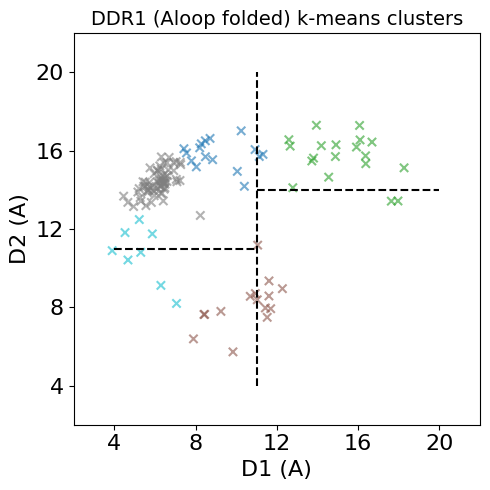

In [11]:
fig=plt.figure(figsize=(5,5))
plt.scatter(d1[np.where(sb < 1)]*10,d2[np.where(sb < 1)]*10, marker='x', alpha=0.6, c=clusters, cmap='tab10')
plt.vlines(11, 4, 20, linestyles='dashed', color='k')
plt.hlines(11, 4, 11, linestyles='dashed', color='k')
plt.hlines(14, 11, 20, linestyles='dashed', color='k')
plt.xlim(2,22)
plt.ylim(2,22)
plt.xlabel('D1 (A)', fontsize=16)
plt.ylabel('D2 (A)', fontsize=16)
plt.xticks(np.arange(4,24,4), fontsize=16)
plt.yticks(np.arange(4,24,4), fontsize=16)
plt.title("DDR1 (Aloop folded) k-means clusters", fontsize=14)
plt.tight_layout()

In [20]:
sb_id = np.where(sb < 1)[0]
decoys = sb_id[np.where(clusters==2)]
for i in decoys:
    frame = traj[i]
    # frame_pdb_file = f'DDR1_frame_{i}.pdb'
    # frame.save_pdb(frame_pdb_file)
    print(i)

74
307
605
671
854
901
915
940
960
1001
1007
1107
1130
1134
1137


In [ ]:
inp = '/content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/dock1/vsw.inp'
with open(inp, 'r') as file:
  jj = file.read()
  pks = re.findall(r'glide-grid_(.*).zip', jj)
for i, pk in enumerate(pks):
  if len(pk[6:]) !=0 :
    if int(pk[6:]) in decoys:
      print(i+1, pk)
      os.system(f"cp /content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/dock1/RMSD_dk_match_{i+1}.csv /content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/RMSD_dk_match_{pk}.csv")

9 frame_74
13 frame_307
15 frame_605
24 frame_854
25 frame_901
29 frame_940
31 frame_960
39 frame_1137


In [ ]:
inp = '/content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/dock2/vsw.inp'
with open(inp, 'r') as file:
  jj = file.read()
  pks = re.findall(r'glide-grid_(.*).zip', jj)
for i, pk in enumerate(pks):
  if len(pk[6:]) !=0 :
    if int(pk[6:]) in decoys:
      print(i+1, pk)
      os.system(f"cp /content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/dock2/RMSD_dk_match_{i+1}.csv /content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/RMSD_dk_match_{pk}.csv")

9 frame_671
11 frame_915
12 frame_1007
13 frame_1130


In [ ]:
inp = '/content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/dock3/vsw.inp'
with open(inp, 'r') as file:
  jj = file.read()
  pks = re.findall(r'glide-grid_(.*).zip', jj)
for i, pk in enumerate(pks):
  if len(pk[6:]) !=0 :
    if int(pk[6:]) in decoys:
      print(i+1, pk)
      os.system(f"cp /content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/dock3/RMSD_dk_match_{i+1}.csv /content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/RMSD_dk_match_{pk}.csv")

1 frame_1001
2 frame_1107
3 frame_1134


In [ ]:
inp = '/content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/dock1/vsw.inp'
with open(inp, 'r') as file:
  jj = file.read()
  pks = re.findall(r'glide-grid_(.*).zip', jj)
for i, pk in enumerate(pks):
  if len(pk[6:]) !=0 :
    if int(pk[6:]) == 0:
      print(i+1, pk)
      os.system(f"cp /content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/dock1/RMSD_dk_match_{i+1}.csv /content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/RMSD_dk_match_{pk}.csv")

5 frame_0


In [ ]:
inp = '/content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/dock1/vsw.inp'
with open(inp, 'r') as file:
  jj = file.read()
  pks = re.findall(r'glide-grid_(.*).zip', jj)
for i, pk in enumerate(pks):
  if len(pk[6:]) ==0 :
    print(i+1, pk)
    os.system(f"cp /content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/dock1/RMSD_dk_match_{i+1}.csv /content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1/RMSD_dk_match_{pk}.csv")

1 3ZOS
2 4BKJ
3 6BRJ
4 6BSD


In [ ]:
decoys =[  74,  307,  605,  671,  854,  901,  915,  940,  960, 1001, 1007, 1107, 1130, 1134, 1137]

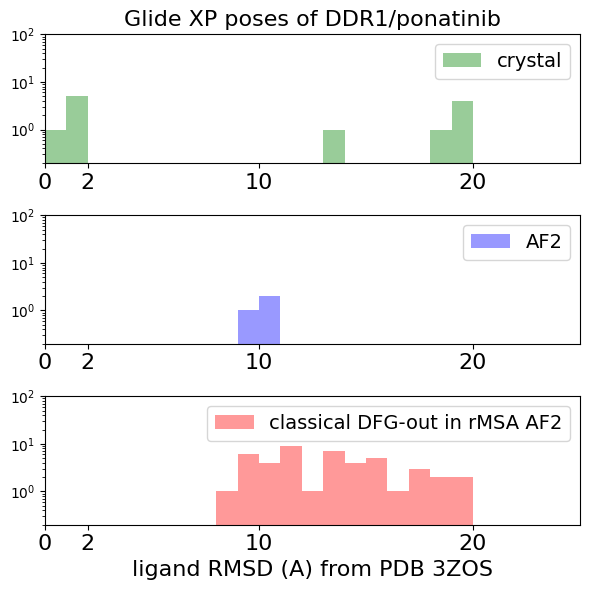

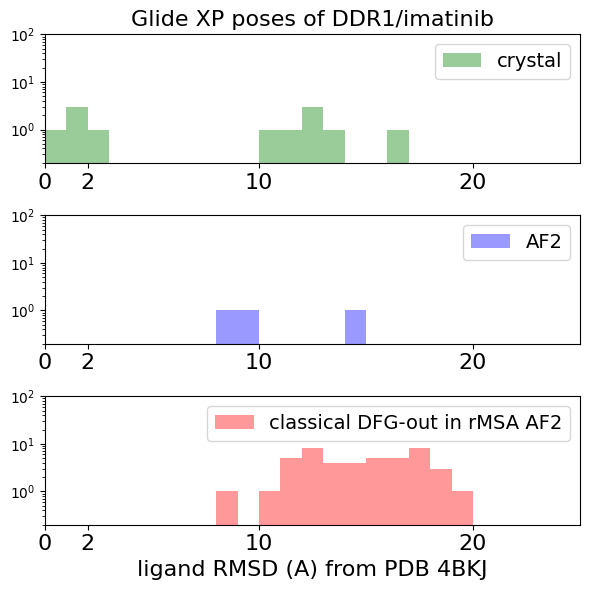

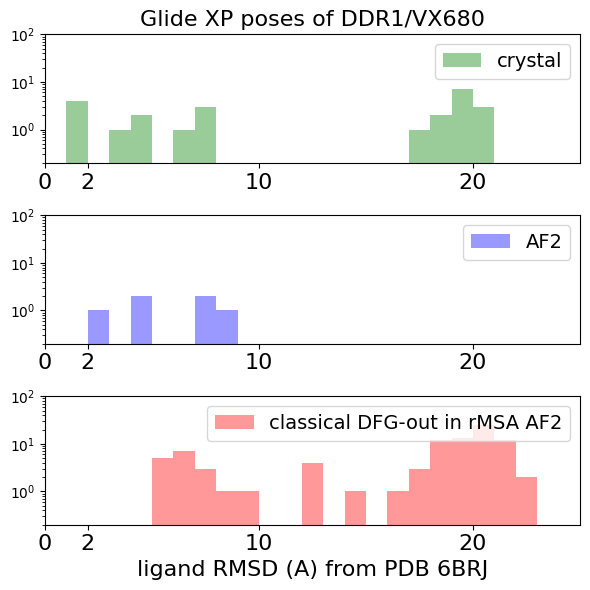

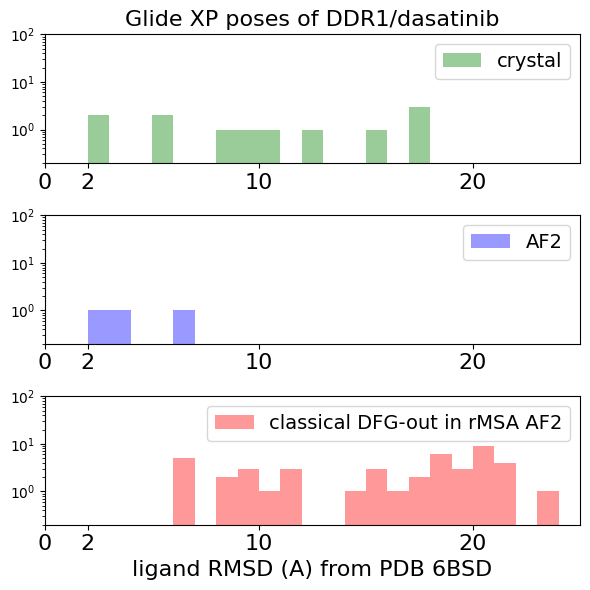

In [ ]:
mcs_ct = 0.7
temps = ['3ZOS','4BKJ','6BRJ','6BSD']
ligs = ['ponatinib', 'imatinib', 'VX680', 'dasatinib']
folder = '/content/drive/MyDrive/AF2RAVE-Glide/Glide_XP/DDR1'
bin = np.arange(0,25,1)
for ii, temp in enumerate(temps):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))
    tmp=[]
    for pk in temps:
        match = pd.read_csv(f'{folder}/RMSD_dk_match_{pk}.csv', header=0, sep=',')
        sub = match[match[f'{temp}_MCS'] > mcs_ct] #Only comparing the same ligand
        tmp.append(list(sub[f'{temp}_RMSD']))
    tmp = np.concatenate(tmp)
    ax1.hist(tmp, color='g', alpha=0.4, bins=bin, label='crystal',log=True)

    tmp=[]
    match = pd.read_csv(f'{folder}/RMSD_dk_match_frame_0.csv', header=0, sep=',')
    sub = match[match[f'{temp}_MCS'] > mcs_ct] #Only comparing the same ligand
    tmp = list(sub[f'{temp}_RMSD'])
    ax2.hist(tmp, color='b', alpha=0.4, bins=bin, label='AF2',log=True)

    tmp=[]
    for pk in decoys:
        match = pd.read_csv(f'{folder}/RMSD_dk_match_frame_{pk}.csv', header=0, sep=',')
        sub = match[match[f'{temp}_MCS'] > mcs_ct] #Only comparing the same ligand
        tmp.append(list(sub[f'{temp}_RMSD']))
    tmp = np.concatenate(tmp)
    ax3.hist(tmp,alpha=0.4, color='r', bins=bin, label='classical DFG-out in rMSA AF2',log=True)

    ax1.set_title(f'Glide XP poses of DDR1/{ligs[ii]}', fontsize=16)
    for ax in (ax1, ax2, ax3):
        ax.set_xlim(0, 25)  # Example x limits
        ax.set_ylim(0.2, 100)  # Example y limits
        ax.set_xticks([0, 2, 10, 20])
        ax.tick_params(axis='x', labelsize=16)
        ax.legend(fontsize=14,loc='upper right')
    ax3.set_xlabel(f'ligand RMSD (A) from PDB {temp}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f"XP_RMSD_{temp}.png",dpi=300)

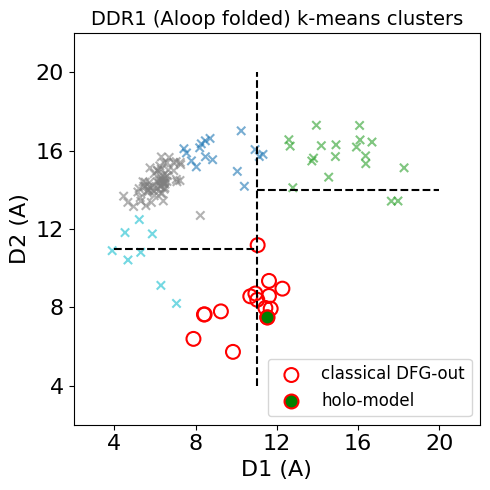

In [21]:
fig=plt.figure(figsize=(5,5))
xx = d1[np.where(sb < 1)]*10
yy = d2[np.where(sb < 1)]*10
rest = np.where(clusters!=2)
plt.scatter(xx[rest], yy[rest], marker='x', alpha=0.6, c=clusters[rest], cmap='tab10')
out= np.where(clusters==2)[0]
plt.scatter(xx[out], yy[out], s=100, facecolors='none', edgecolors='r',linewidths=1.5,label='classical DFG-out')
plt.scatter(xx[out[0]], yy[out[0]], s=100, facecolors='g', edgecolors='r',linewidths=1.5, label='holo-model')
plt.vlines(11, 4, 20, linestyles='dashed', color='k')
plt.hlines(11, 4, 11, linestyles='dashed', color='k')
plt.hlines(14, 11, 20, linestyles='dashed', color='k')
plt.xlim(2,22)
plt.ylim(2,22)
plt.xlabel('D1 (A)', fontsize=16)
plt.ylabel('D2 (A)', fontsize=16)
plt.xticks(np.arange(4,24,4), fontsize=16)
plt.yticks(np.arange(4,24,4), fontsize=16)
plt.title("DDR1 (Aloop folded) k-means clusters", fontsize=14)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig(f"DDR1_rAF2_aloop_cluster.png",dpi=300)

In [ ]:
ligs = ['ponatinib', 'imatinib']
temps = ['3ZOS','4BKJ']
folder = '/content/drive/MyDrive/AF2RAVE-Glide/IFD_valid/DDR1/'

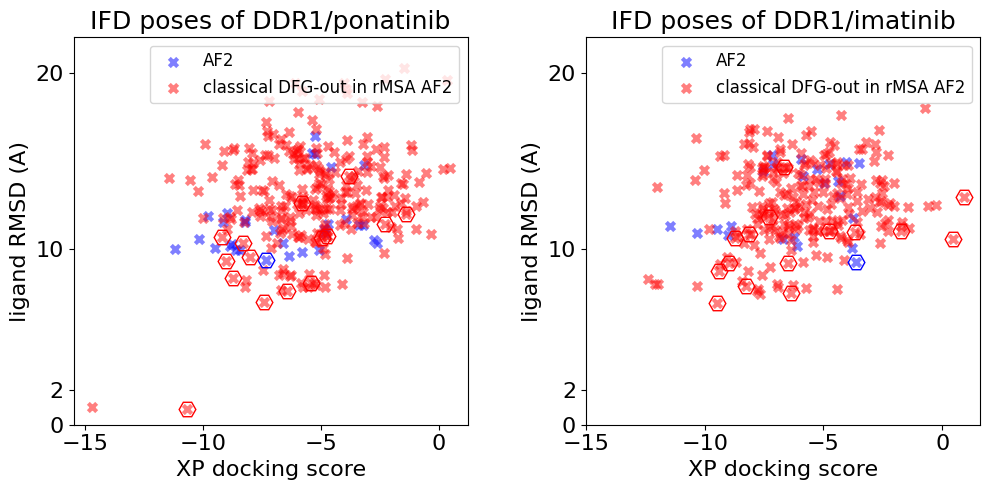

In [ ]:
fig=plt.figure(figsize=(10,5))
mcs_ct = 0.7
pres=[  74,  307,  605,  671,  854,  901,  915,  940,  960, 1001, 1007, 1107, 1130, 1134, 1137]
for ii, temp in enumerate(temps):
    pre = 0
    match = pd.read_csv(f'{folder}/{pre}_match.csv', header=0, sep=',')
    plt.subplot(1,2,ii+1)
    sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
    L_RMSDs = np.array(sub[f'{temp}_l_RMSD'])
    dk_s = np.array(sub['r_i_docking_score'])

    plt.scatter(dk_s, L_RMSDs, alpha=0.5, marker='x', color='b', linewidth=3, label='AF2')
    mark = np.argmin(L_RMSDs)
    plt.plot(dk_s[mark], L_RMSDs[mark],"H",markerfacecolor="none",markeredgecolor="b",markersize=12)


    L_RMSDs=[]
    dk_s=[]
    marks=[]
    for pre in pres:
        match = pd.read_csv(f'{folder}/{pre}_match.csv', header=0, sep=',')
        sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
        mark = sum(len(sublist) for sublist in L_RMSDs) + np.argmin(sub[f'{temp}_l_RMSD'])
        L_RMSDs.append(list(sub[f'{temp}_l_RMSD']))
        dk_s.append(list(sub['r_i_docking_score']))
        marks.append(mark)

    L_RMSDs = np.concatenate(L_RMSDs)
    dk_s = np.concatenate(dk_s)
    plt.scatter(dk_s,L_RMSDs, alpha=0.5, marker='x', color='r', linewidth=3, label='classical DFG-out in rMSA AF2')
    plt.plot(dk_s[marks], L_RMSDs[marks],"H",markerfacecolor="none",markeredgecolor="r",markersize=12)


    plt.ylabel('ligand RMSD (A)', fontsize=16)
    plt.xlabel('XP docking score', fontsize=16)
    plt.yticks([0,2,10,20], fontsize=16)
    plt.xticks([-15,-10,-5,0], fontsize=16)
    plt.ylim(0,22)
    plt.title(f"IFD poses of DDR1/{ligs[ii]}", fontsize=18)
    plt.legend(fontsize=12,loc='upper right')
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"DDR1_rAF2_docking.png",dpi=300)

**DiffDock for rMSA AF2**

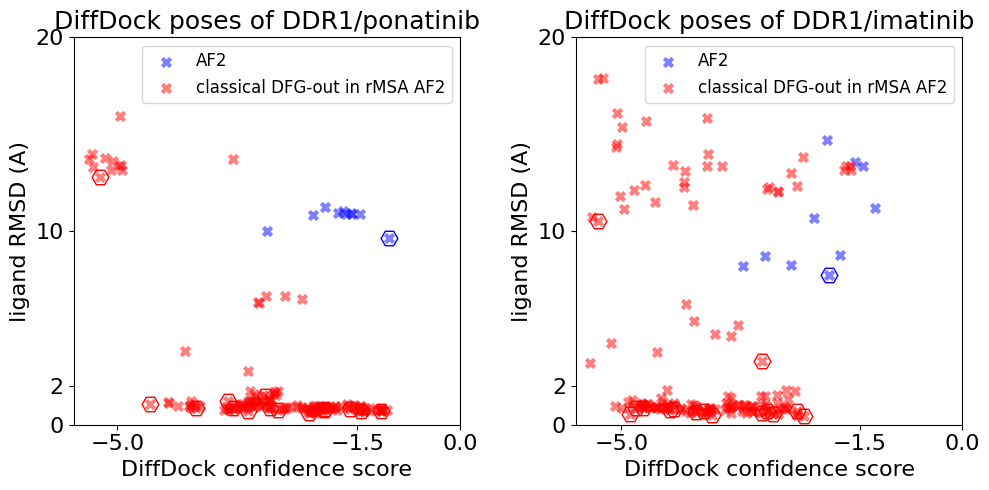

In [ ]:
fig=plt.figure(figsize=(10,5))
mcs_ct = 0.7
pres=[  74,  307,  605,  671,  854,  901,  915,  940,  960, 1001, 1007, 1107, 1130, 1134, 1137]
folder = '/content/drive/MyDrive/AF2RAVE-Glide/DiffDock'
temps = ['3ZOS','4BKJ']
ligs = ['ponatinib', 'imatinib']

for ii, temp in enumerate(temps):
    pre = 0
    match = pd.read_csv(f'{folder}/RMSD_dk_match_{pre}.csv', header=0, sep=',')
    plt.subplot(1,2,ii+1)
    sub = match[match[f'{temp}_MCS'] > mcs_ct] #Only comparing the same ligand
    L_RMSDs = np.array(sub[f'{temp}_RMSD'])
    dk_s = np.array(sub['conf_score'])

    plt.scatter(dk_s, L_RMSDs, alpha=0.5, marker='x', color='b', linewidth=3, label='AF2')
    mark = np.argmin(L_RMSDs)
    plt.plot(dk_s[mark], L_RMSDs[mark],"H",markerfacecolor="none",markeredgecolor="b",markersize=12)


    L_RMSDs=[]
    dk_s=[]
    marks=[]
    for pre in pres:
        match = pd.read_csv(f'{folder}/RMSD_dk_match_{pre}.csv', header=0, sep=',')
        sub = match[match[f'{temp}_MCS'] > mcs_ct] #Only comparing the same ligand
        mark = sum(len(sublist) for sublist in L_RMSDs) + np.argmin(sub[f'{temp}_RMSD'])
        L_RMSDs.append(list(sub[f'{temp}_RMSD']))
        dk_s.append(list(sub['conf_score']))
        marks.append(mark)

    L_RMSDs = np.concatenate(L_RMSDs)
    dk_s = np.concatenate(dk_s)
    plt.scatter(dk_s,L_RMSDs, alpha=0.5, marker='x', color='r', linewidth=3, label='classical DFG-out in rMSA AF2')
    plt.plot(dk_s[marks], L_RMSDs[marks],"H",markerfacecolor="none",markeredgecolor="r",markersize=12)


    plt.ylabel('ligand RMSD (A)', fontsize=16)
    plt.xlabel('DiffDock confidence score', fontsize=16)
    plt.yticks([0,2,10,20], fontsize=16)
    plt.xticks([-5,-1.5, 0], fontsize=16)
    plt.ylim(0,20)
    plt.title(f"DiffDock poses of DDR1/{ligs[ii]}", fontsize=18)
    plt.legend(fontsize=12)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"DDR1_diffDock_dk_vs_lRMSD",dpi=300)

**Prior info cluster for rAF2 Abl1**

In [ ]:
from kinaseCVs import resids_Abl1

In [ ]:
traj = md.load("rAF2/Abl1/Abl1_AF2.xtc", top='rAF2/Abl1/Abl1_MSA16/pred_1.pdb')
d1 = kcv.dunbrack1(resids_Abl1,traj.top,traj).traj
d2 = kcv.dunbrack2(resids_Abl1,traj.top,traj).traj
sb = kcv.SB_CB_chodera(resids_Abl1,traj.top,traj).traj

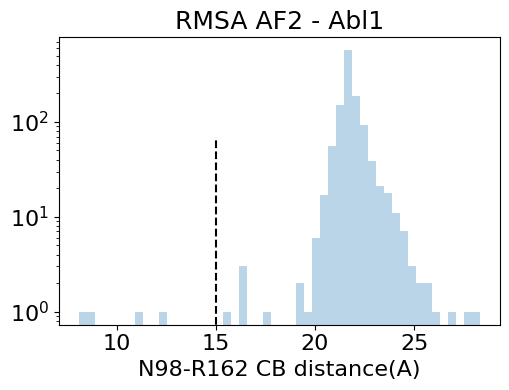

In [ ]:
sb_ct = 1.5
fig=plt.figure(figsize=(5.2,4))
plt.hist(sb*10, alpha=0.3, bins=50,log=True)
plt.vlines(sb_ct*10, 0, 70, 'k', linestyles='dashed')
plt.xlabel('N98-R162 CB distance(A)', fontsize=16)
#plt.ylim(0,2.5)
plt.xticks([10,15,20,25], fontsize=16)
plt.yticks(fontsize=16)
plt.title(f"RMSA AF2 - Abl1", fontsize=18)
plt.tight_layout()

In [ ]:
X = np.transpose([d1[np.where(sb <sb_ct)],d2[np.where(sb < sb_ct)]])
model = KMeans(n_clusters=2, n_init=10)
clusters = model.fit_predict(X)

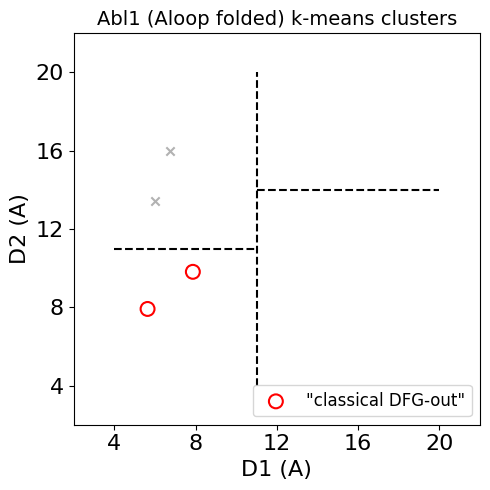

In [ ]:
fig=plt.figure(figsize=(5,5))

xx = d1[np.where(sb < sb_ct)]*10
yy = d2[np.where(sb < sb_ct)]*10
rest = np.where(clusters!=1)
plt.scatter(xx[rest], yy[rest], marker='x', alpha=0.6, color='gray')
out= np.where(clusters==1)[0]
plt.scatter(xx[out], yy[out], s=100, facecolors='none', edgecolors='r',linewidths=1.5,label='"classical DFG-out"')
plt.vlines(11, 4, 20, linestyles='dashed', color='k')
plt.hlines(11, 4, 11, linestyles='dashed', color='k')
plt.hlines(14, 11, 20, linestyles='dashed', color='k')
plt.xlim(2,22)
plt.ylim(2,22)
plt.xlabel('D1 (A)', fontsize=16)
plt.ylabel('D2 (A)', fontsize=16)
plt.xticks(np.arange(4,24,4), fontsize=16)
plt.yticks(np.arange(4,24,4), fontsize=16)
plt.title("Abl1 (Aloop folded) k-means clusters", fontsize=14)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig(f"Abl1_rAF2_aloop_cluster.png",dpi=300)

**IFD for rMSA AF2**

In [ ]:
ligs = ['ponatinib', 'imatinib']
temps = ['3OXZ','2HYY']
folder = '/content/drive/MyDrive/AF2RAVE-Glide/IFD_valid/Abl1/'

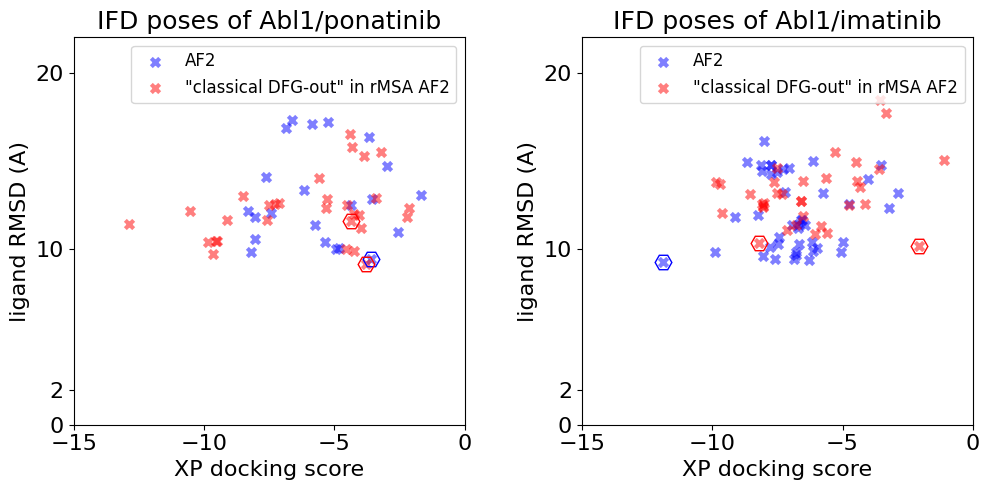

In [ ]:
fig=plt.figure(figsize=(10,5))
mcs_ct = 0.7
pres=[1094, 1136]
for ii, temp in enumerate(temps):
    pre = 0
    match = pd.read_csv(f'{folder}/{pre}_match.csv', header=0, sep=',')
    plt.subplot(1,2,ii+1)
    sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
    L_RMSDs = np.array(sub[f'{temp}_l_RMSD'])
    dk_s = np.array(sub['r_i_docking_score'])

    plt.scatter(dk_s, L_RMSDs, alpha=0.5, marker='x', color='b', linewidth=3, label='AF2')
    mark = np.argmin(L_RMSDs)
    plt.plot(dk_s[mark], L_RMSDs[mark],"H",markerfacecolor="none",markeredgecolor="b",markersize=12)


    L_RMSDs=[]
    dk_s=[]
    marks=[]
    for pre in pres:
        match = pd.read_csv(f'{folder}/{pre}_match.csv', header=0, sep=',')
        sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
        mark = sum(len(sublist) for sublist in L_RMSDs) + np.argmin(sub[f'{temp}_l_RMSD'])
        L_RMSDs.append(list(sub[f'{temp}_l_RMSD']))
        dk_s.append(list(sub['r_i_docking_score']))
        marks.append(mark)

    L_RMSDs = np.concatenate(L_RMSDs)
    dk_s = np.concatenate(dk_s)
    plt.scatter(dk_s,L_RMSDs, alpha=0.5, marker='x', color='r', linewidth=3, label='"classical DFG-out" in rMSA AF2')
    plt.plot(dk_s[marks], L_RMSDs[marks],"H",markerfacecolor="none",markeredgecolor="r",markersize=12)


    plt.ylabel('ligand RMSD (A)', fontsize=16)
    plt.xlabel('XP docking score', fontsize=16)
    plt.yticks([0,2,10,20], fontsize=16)
    plt.xticks([-15,-10,-5,0], fontsize=16)
    plt.ylim(0,22)
    plt.title(f"IFD poses of Abl1/{ligs[ii]}", fontsize=18)
    plt.legend(fontsize=12,loc='upper right')
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"Abl1_rAF2_docking.png",dpi=300)

**IFD for tAF2**

In [ ]:
folder = '/content/drive/MyDrive/AF2RAVE-Glide/tAF2_Abl1'
file_paths = glob.glob(f'{folder}/frames/*')
pres = [os.path.basename(file_name)[:-4] for file_name in file_paths]
ligs = ['ponatinib', 'imatinib']
temps = ['3OXZ','2HYY']

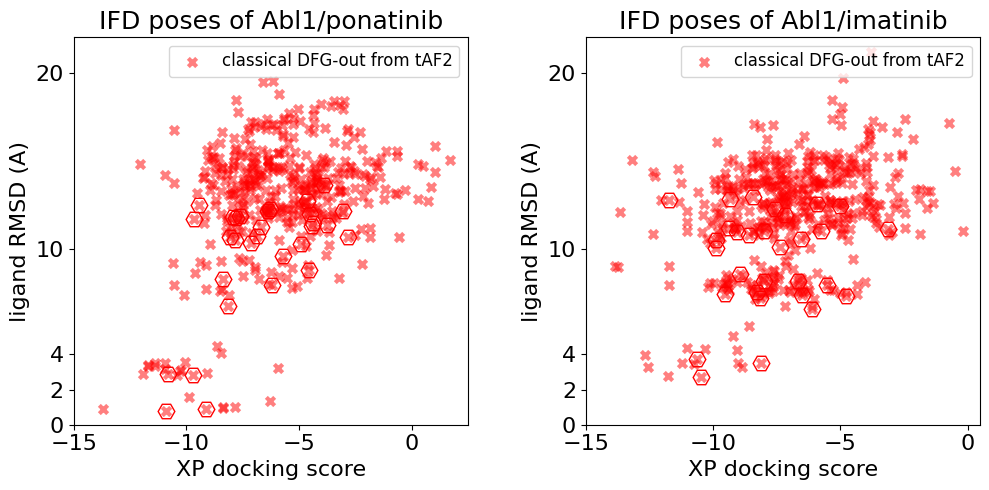

In [ ]:
fig=plt.figure(figsize=(10,5))
mcs_ct = 0.7

for ii, temp in enumerate(temps):
    plt.subplot(1,2,ii+1)

    L_RMSDs=[]
    dk_s=[]
    marks=[]
    for pre in pres:
        match = pd.read_csv(f'{folder}/{pre}_match.csv', header=0, sep=',')
        sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
        mark = sum(len(sublist) for sublist in L_RMSDs) + np.argmin(sub[f'{temp}_l_RMSD'])
        L_RMSDs.append(list(sub[f'{temp}_l_RMSD']))
        dk_s.append(list(sub['r_i_docking_score']))
        marks.append(mark)

    L_RMSDs = np.concatenate(L_RMSDs)
    dk_s = np.concatenate(dk_s)
    plt.scatter(dk_s,L_RMSDs, alpha=0.5, marker='x', color='r', linewidth=3, label='classical DFG-out from tAF2')
    plt.plot(dk_s[marks], L_RMSDs[marks],"H",markerfacecolor="none",markeredgecolor="r",markersize=12)


    plt.ylabel('ligand RMSD (A)', fontsize=16)
    plt.xlabel('XP docking score', fontsize=16)
    plt.yticks([0,2,4,10,20], fontsize=16)
    plt.xticks([-15,-10,-5,0], fontsize=16)
    plt.ylim(0,22)
    plt.title(f"IFD poses of Abl1/{ligs[ii]}", fontsize=18)
    plt.legend(fontsize=12,loc='upper right')
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"Abl1_tAF2_dk_lRMSD",dpi=300)

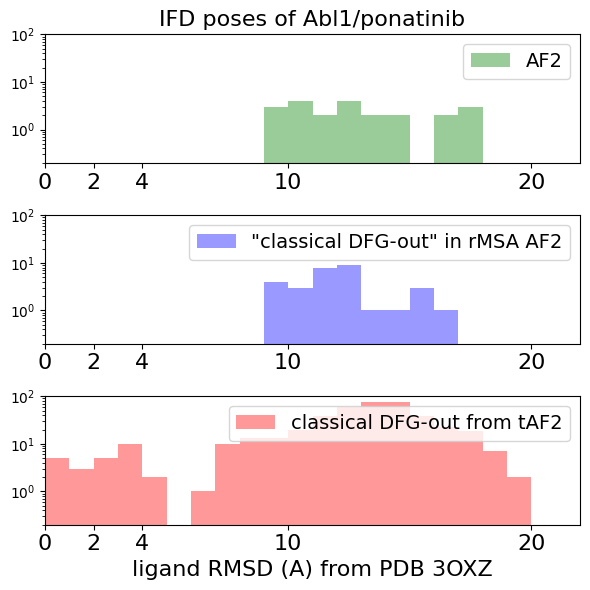

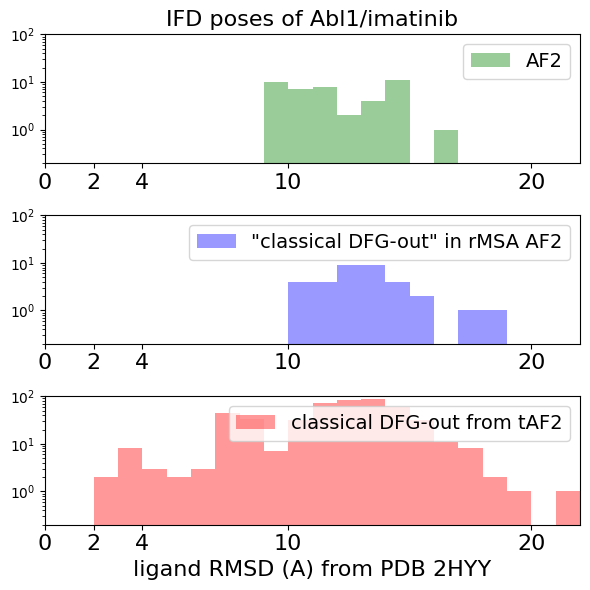

In [ ]:
ligs = ['ponatinib', 'imatinib']
temps = ['3OXZ','2HYY']
folder = '/content/drive/MyDrive/AF2RAVE-Glide/tAF2_Abl1'
rAF2_folder = '/content/drive/MyDrive/AF2RAVE-Glide/IFD_valid/Abl1/'
rAF2_pres=[1094, 1136]

file_paths = glob.glob(f'{folder}/frames/*')
pres = [os.path.basename(file_name)[:-4] for file_name in file_paths]

mcs_ct = 0.7
bin = np.arange(0,25,1)

for ii, temp in enumerate(temps):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

    match = pd.read_csv(f'{rAF2_folder}/0_match.csv', header=0, sep=',')
    sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
    L_RMSDs = np.array(sub[f'{temp}_l_RMSD'])
    ax1.hist(L_RMSDs, color='g', alpha=0.4, bins=bin, label='AF2',log=True)


    L_RMSDs=[]
    for pre in rAF2_pres:
        match = pd.read_csv(f'{rAF2_folder}/{pre}_match.csv', header=0, sep=',')
        sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
        L_RMSDs.append(list(sub[f'{temp}_l_RMSD']))
    L_RMSDs = np.concatenate(L_RMSDs)
    ax2.hist(L_RMSDs, color='b', alpha=0.4, bins=bin, label='"classical DFG-out" in rMSA AF2',log=True)

    L_RMSDs=[]
    for pre in pres:
        match = pd.read_csv(f'{folder}/{pre}_match.csv', header=0, sep=',')
        sub = match[match[f'{temp}_l_MCS'] > mcs_ct] #Only comparing the same ligand
        L_RMSDs.append(list(sub[f'{temp}_l_RMSD']))
    L_RMSDs = np.concatenate(L_RMSDs)
    ax3.hist(L_RMSDs,alpha=0.4, color='r', bins=bin, label='classical DFG-out from tAF2',log=True)

    ax1.set_title(f"IFD poses of Abl1/{ligs[ii]}", fontsize=16)
    for ax in (ax1, ax2, ax3):
        ax.set_xlim(0, 22)  # Example x limits
        ax.set_ylim(0.2, 100)  # Example y limits
        ax.set_xticks([0, 2, 4, 10, 20])
        ax.tick_params(axis='x', labelsize=16)
        ax.legend(fontsize=14,loc='upper right')
    ax3.set_xlabel(f'ligand RMSD (A) from PDB {temp}', fontsize=16)
    #plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.savefig(f"tAF2_lRMSD_{temp}.png",dpi=300)